In [1]:
import numpy as np                                # importing numpy and sep libraries
import sep

from astropy.io import fits

import matplotlib.pyplot as plt                   # plotting
from matplotlib import rcParams

%matplotlib inline

rcParams["figure.figsize"] = [10.0, 8.0]

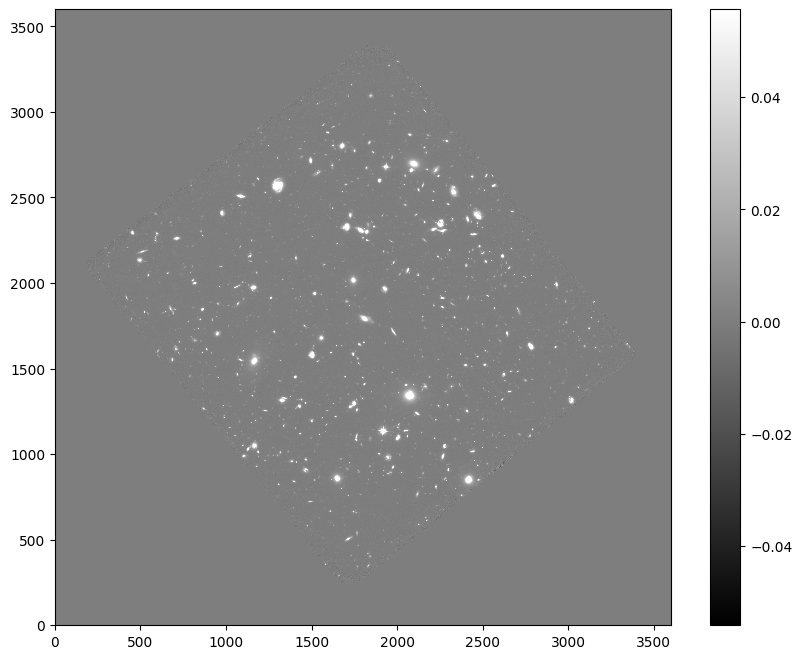

In [10]:
data = fits.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")                      # read image into 2D array
data = np.ascontiguousarray(data.astype(np.float32))

m, s = np.mean(data), np.std(data)                                                             # shows image
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

*(not sure why it's rotated, might have to do with sky coordinates not being aligned with array axes, but in terms of following the tutorial this should still be the expected output)*

In [12]:
bkg = sep.Background(data)  # measures spatially varying background on the image

In [14]:
print(bkg.globalback)   # getting global mean and noise of image background
print(bkg.globalrms)

0.0
0.0005398219218477607


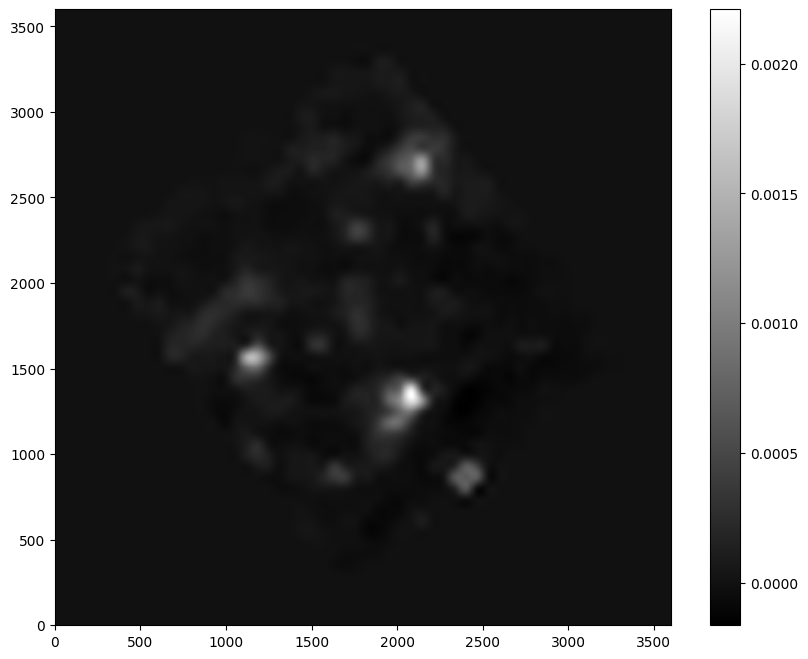

In [17]:
bkg_image = bkg.back()                                                      # background as 2D array, same size as original image

plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower') # show background
plt.colorbar();

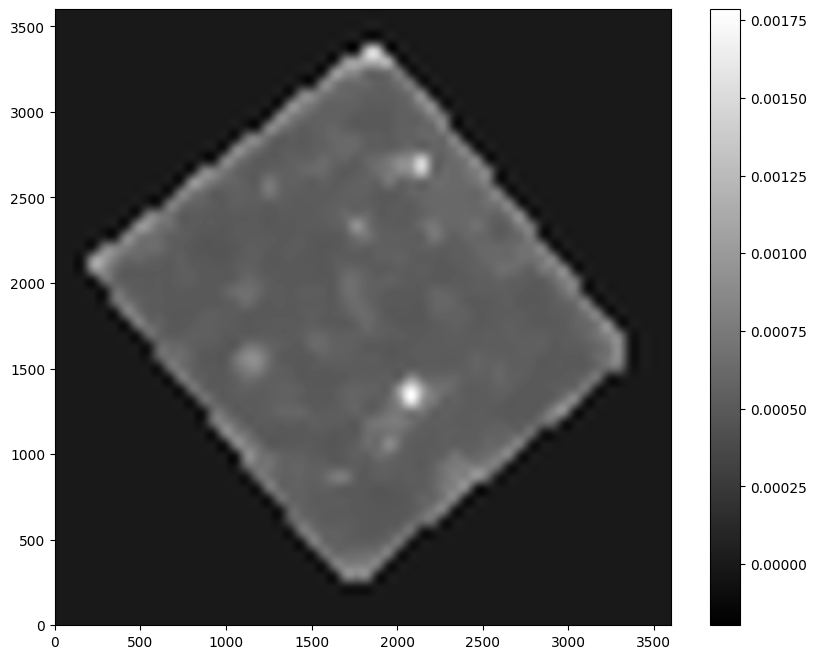

In [18]:
bkg_rms = bkg.rms()                                                       # background noise as 2D array, same size as original image

plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower') # show background noise
plt.colorbar();

In [19]:
data_sub = data - bkg      # subtract background

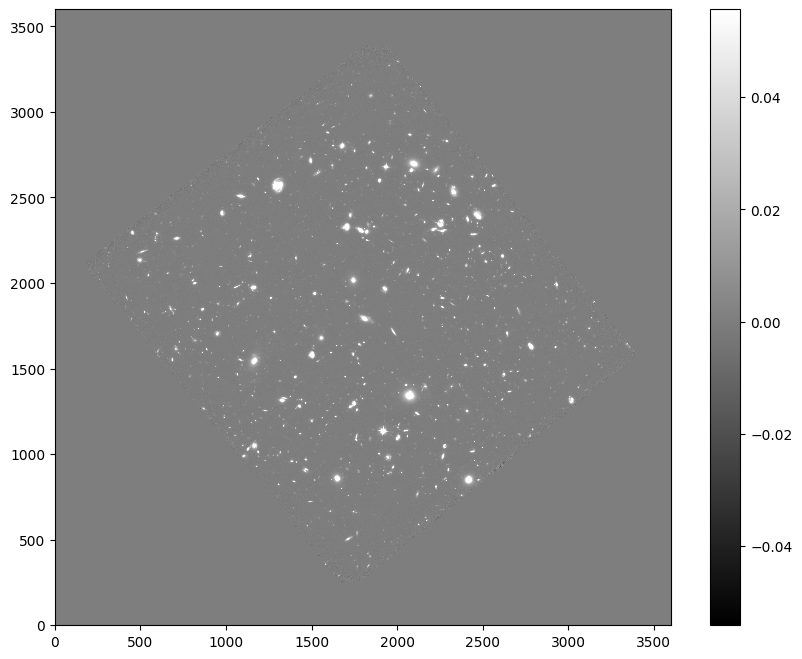

In [21]:
# showing background subtracted image
m_sub, s_sub = np.mean(data_sub), np.std(data_sub)
plt.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m_sub - s_sub, vmax=m_sub + s_sub, origin='lower')
plt.colorbar();

In [50]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms) # object detection for background subtracted image, using same 1.5 sigma threshold as the tutorial

In [51]:
len(objects)  # number of objects detected

8643

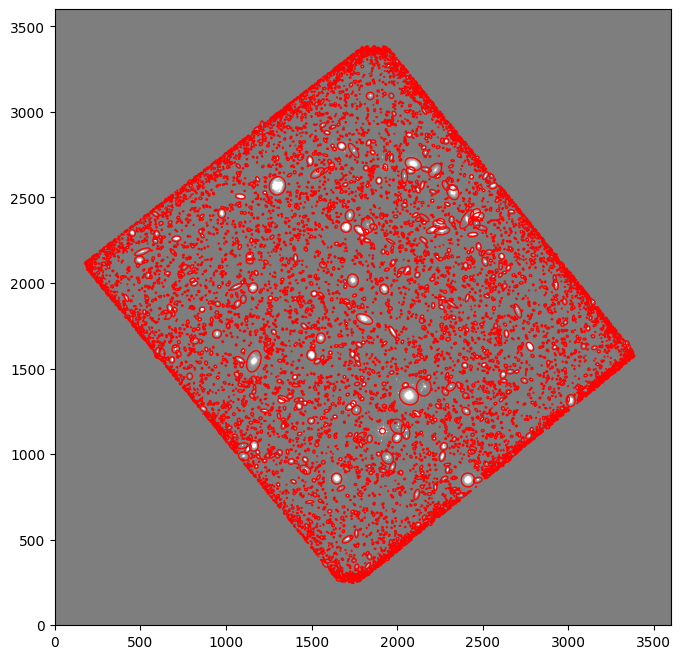

In [53]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object (this is going to be kind of crazy with 8643 objects)
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180.0 / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [54]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)
# flux, fluxerr and flag are all 1-D arrays with one entry per object

In [55]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} =/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 =/- 0.176890
object 1: flux = 0.031018 =/- 0.176142
object 2: flux = -0.024388 =/- 0.002883
object 3: flux = 0.001947 =/- 0.044219
object 4: flux = 0.012457 =/- 0.111649
object 5: flux = -0.011228 =/- 0.002875
object 6: flux = 0.029368 =/- 0.171394
object 7: flux = -0.009126 =/- 0.002875
object 8: flux = 0.048023 =/- 0.219161
object 9: flux = 0.027840 =/- 0.166877


**notes:** these flux values are a lot smaller in magnitude than the ones from the tutorial!

In [62]:
good = (flag == 0) & np.isfinite(flux) & (flux > 0.0)   # this keeps only the good sources, so no flags, a finite flux, and positive flux
flux_good = flux[good]
print("number of good sources:", len(flux_good))

mean_flux = np.mean(flux_good)                            # data analysis
median_flux = np.median(flux_good)
std_flux = np.std(flux_good)

print("Mean flux:", mean_flux)
print("Median flux:", median_flux)
print("Std dev:", std_flux)

number of good sources: 8470
Mean flux: 0.3693758514069677
Median flux: 0.03168995098851156
Std dev: 9.335668949664433


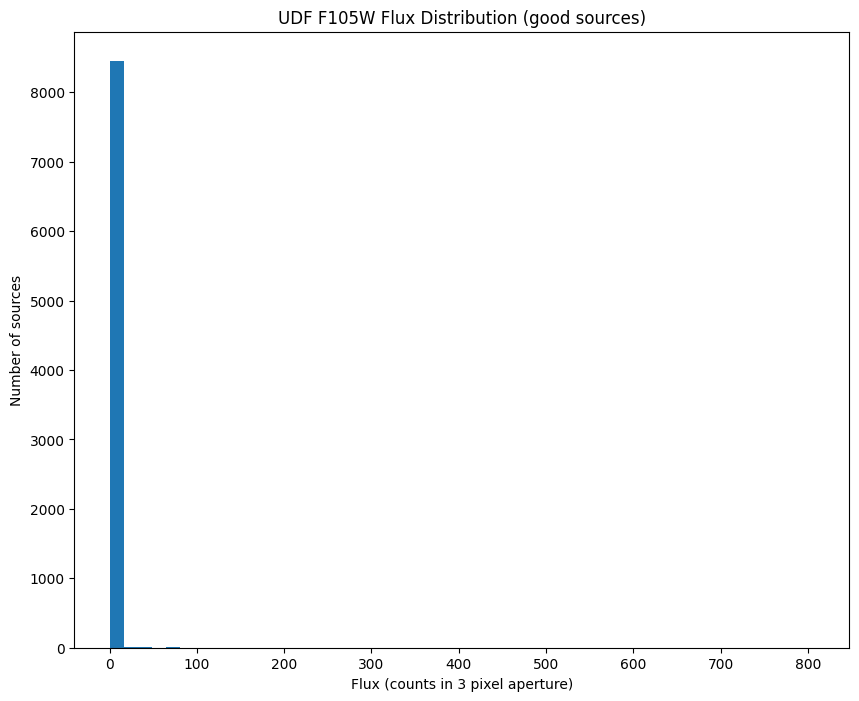

In [63]:
plt.hist(flux_good, bins=50)   # histogram of fluxes
plt.xlabel("Flux (counts in 3 pixel aperture)")
plt.ylabel("Number of sources")
plt.title("UDF F105W Flux Distribution (good sources)")
plt.show()

**notes:** most of UDF galaxies have fluxes close to 0-10 because they are really faint sources, so the giant spike there is expected, so the ones that are extremely apparent only end up actually making up an extreme minority of the over 8000

In [66]:
z = (flux_good - mean_flux) / std_flux     # need z score, which is how many standard deviations each good flux is from mean

imax_good = np.argmax(z)                   #  largest z score in good only array
max_flux = flux_good[imax_good]
max_z = z[imax_good]

print("Brightest outlier flux:", max_flux)
print("Z Score (sigma above mean):", max_z)

Brightest outlier flux: 807.2972835731507
Z Score (sigma above mean): 86.43493166611789


 **notes**: this z score basically means that the mean is being dominated by those 8000 faint galaxies, and so
        that very small number of bright galaxies with fluxes in the hundreds end up really far above the mean

In [69]:
# need to get SEP to track down which object is the one that was found to be the brightest
indices = np.arange(len(flux))                           # indices of all elements
good_indices = indices[good]                             # indices of the good ones
imax_full = good_indices[imax_good]                      # index of this outlier in teh full arrays
print("Object index in 'objects' array:", imax_full)     # object located

Object index in 'objects' array: 2069


**notes:** this means that object #2069 across all the SEP detections is the one that is brightest

In [71]:
# need to find coordinates of this outlier
x_outlier = objects['x'][imax_full]
y_outlier = objects['y'][imax_full]

print("outlier coordinates (x, y):", x_outlier, y_outlier)

outlier coordinates (x, y): 1914.2549094883857 1134.3164850742164


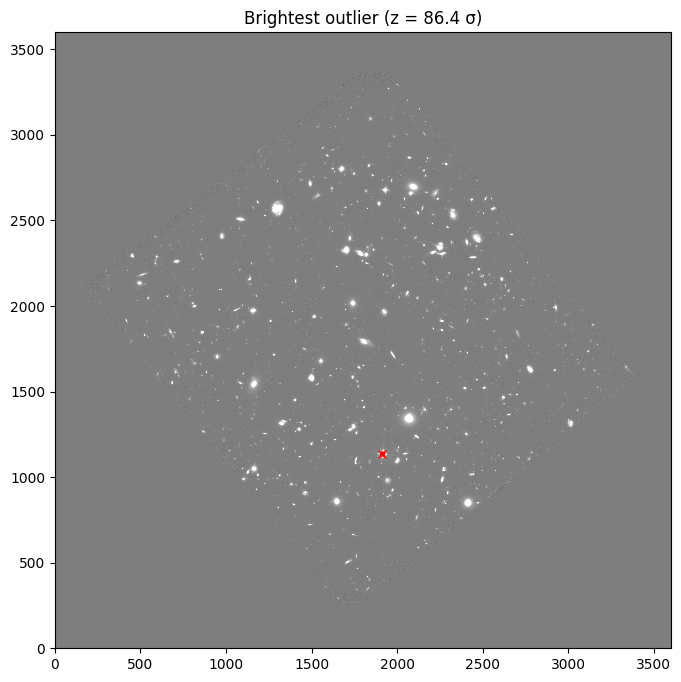

In [75]:
# and showing wwhere this is on the image
fig, ax = plt.subplots()
ax.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m_sub - s_sub, vmax=m_sub + s_sub, origin='lower')

circle = plt.Circle((x_outlier, y_outlier), 8.0, edgecolor='red', facecolor='none', linewidth=2) # marking this outlier with circle
ax.add_patch(circle)
ax.plot(x_outlier, y_outlier, 'x', color='red')

ax.set_title("Brightest outlier (z = {:.1f} σ)".format(max_z))

plt.show()